In [1]:
from visualize.hindsight_improvability import *
from eval import get_preds_earlyexiting
from utils_notebook import *
from utils import load_model

import argparse
from pathlib import Path
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

import copy

/home/metod/miniconda3/envs/ztw_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
os.environ['CIFAR100_PATH'] = "/home/metod/Desktop/PhD/year1/PoE/Zero-Time-Waste/ztw_rewrite/data/cifar100"

In [4]:
parser = argparse.ArgumentParser()
ARGS = parser.parse_args(args=[])
ARGS.runs_dir = Path.cwd() / 'runs'
ARGS.exp_names = ["cifar100_resnet50_IHYWUAYB", "cifar100_ztw_cascading_5377D53A", "cifar100_ztw_ensembling_SOVJE4OA"]
ARGS.exp_ids = [0]
ARGS.display_names = None
ARGS.use_wandb = False
ARGS.output_dir = Path.cwd() / 'figures'
ARGS.output_name = 'hi'

In [5]:
MODEL_ZTW_BASE = 'cifar100_ztw_cascading_5377D53A_0'
MODEL_ZTW_ENSEMBLING = 'cifar100_ztw_ensembling_SOVJE4OA_0'

## 1 Hindsight Improvability

In [6]:
logits_dict = {}
labels_dict = {}
hi_stats = {}
for exp_name in ARGS.exp_names:
    for exp_id in ARGS.exp_ids:
        run_name = f'{exp_name}_{exp_id}'
        print(f'Calculating hindsight improvabilities for: {run_name}')
        ee_preds, labels = get_predictions(ARGS, run_name)
        if ee_preds is not None:
            logits_dict[run_name] = torch.stack(ee_preds)
            labels_dict[run_name] = labels
            stats = {'hi': calculate_hindsight_improvability(ee_preds, labels)}
            hi_stats[run_name] = stats
hi_stats = calculate_mean_std(ARGS.exp_names, ARGS.exp_ids, hi_stats)

Calculating hindsight improvabilities for: cifar100_resnet50_IHYWUAYB_0
Calculating hindsight improvabilities for: cifar100_ztw_cascading_5377D53A_0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Calculating hindsight improvabilities for: cifar100_ztw_ensembling_SOVJE4OA_0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
logits_dict.keys()

dict_keys(['cifar100_ztw_cascading_5377D53A_0', 'cifar100_ztw_ensembling_SOVJE4OA_0'])

In [8]:
logits, targets = logits_dict[MODEL_ZTW_BASE].cpu(), labels_dict[MODEL_ZTW_BASE].cpu()
logits_ztw_ens, targets_ztw_ens = logits_dict[MODEL_ZTW_ENSEMBLING].cpu(), labels_dict[MODEL_ZTW_ENSEMBLING].cpu()

In [9]:
L = len(logits)
N = len(targets)

In [10]:
assert (targets == targets_ztw_ens).sum() == N

In [11]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

In [12]:
probs_ztw_ens = torch.softmax(logits_ztw_ens, dim=2)
preds_ztw_ens = {i: torch.argmax(probs_ztw_ens, dim=2)[i, :] for i in range(L)}
acc_ztw_ens = [(targets == preds_ztw_ens[i]).sum() / len(targets) for i in range(L)]

In [13]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

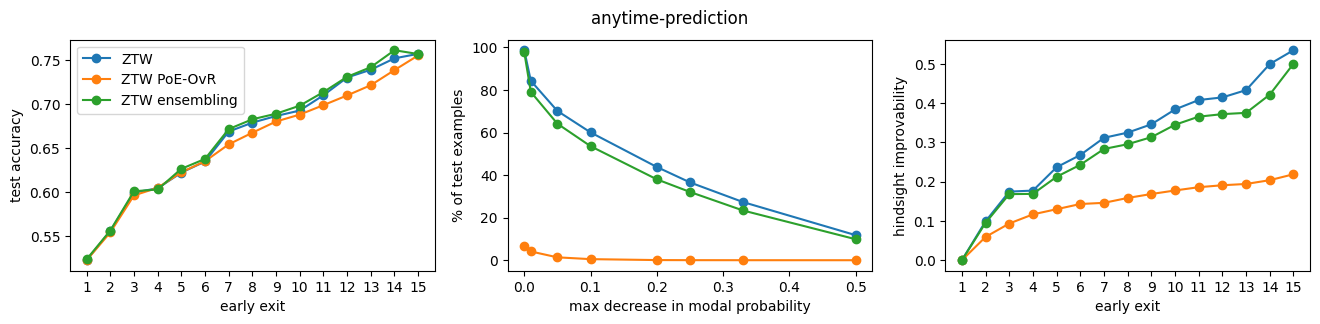

In [14]:
early_exits = [i + 1 for i in range(L)]

fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(early_exits, acc, label='ZTW', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='ZTW PoE-OvR', marker='o',)
ax[0].plot(early_exits, acc_ztw_ens, label='ZTW ensembling', marker='o',)
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'ZTW'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'ZTW PoE-OvR'),
                            (preds_ztw_ens, probs_ztw_ens, 'ZTW ensembling'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    ax[2].plot(early_exits, calculate_hindsight_improvability([_probs[l] for l in range(L)], targets), marker='o', label=label)

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('hindsight improvability')

ax[0].set_xticks(early_exits)
ax[2].set_xticks(early_exits)

ax[0].legend()
plt.suptitle(f'anytime-prediction')
plt.show()

## 2 Geometric Ensemble params

In [15]:
ee_model, ee_state = load_model(ARGS, MODEL_ZTW_ENSEMBLING)

N_ee = ee_model._base_model.number_of_attached_heads

### 2.0 Visualize ensemble params 

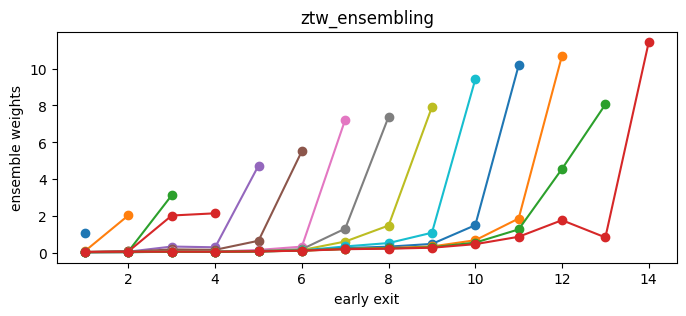

In [41]:
early_exits = [i + 1 for i in range(N_ee)]
ens_weights_dict = {}
ens_bias_dict = {}
fig, ax = plt.subplots(figsize=(8, 3))
for l in range(N_ee):
    weights_l = np.exp(ee_model._ensembles[l]._weight.cpu().detach().numpy().reshape(-1))
    bias_l = np.exp(ee_model._ensembles[l]._bias.cpu().detach().numpy().reshape(-1))
    plt.plot(early_exits[:l + 1], weights_l, marker='o')
    ens_weights_dict[l] = weights_l
    ens_bias_dict[l] = bias_l
plt.xlabel('early exit')
plt.ylabel('ensemble weights')
plt.title('ztw_ensembling')
plt.show()

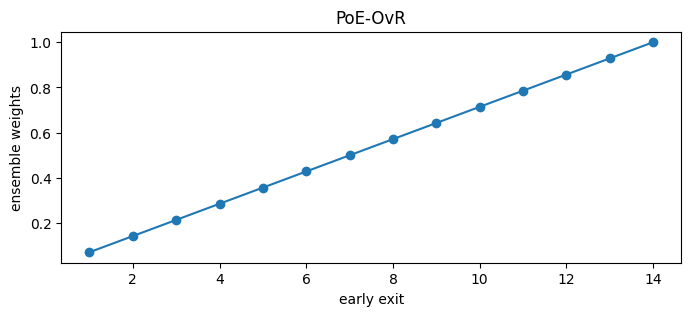

In [42]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(early_exits, (np.arange(1, N_ee + 1, 1, dtype=float) / N_ee), marker='o')
plt.xlabel('early exit')
plt.ylabel('ensemble weights')
plt.title('PoE-OvR')
plt.show()

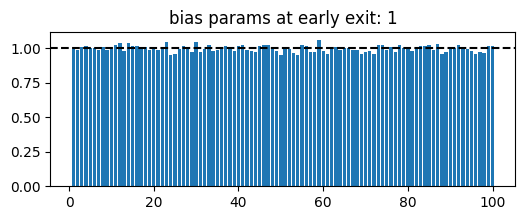

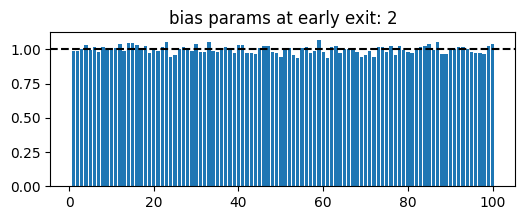

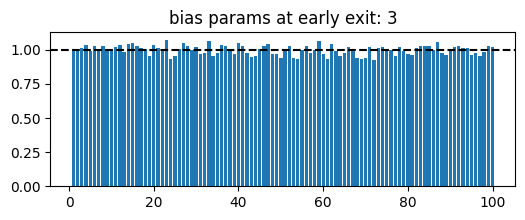

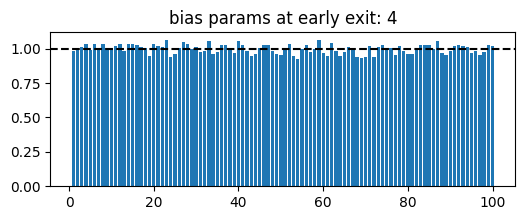

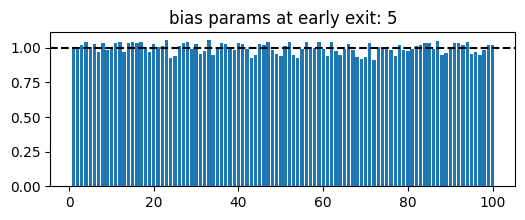

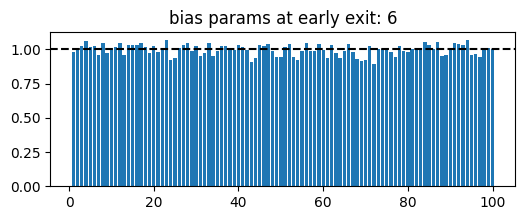

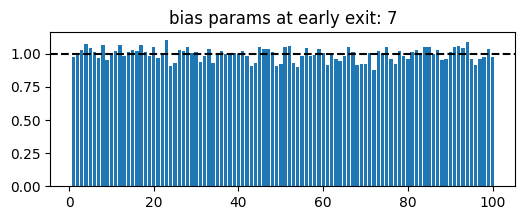

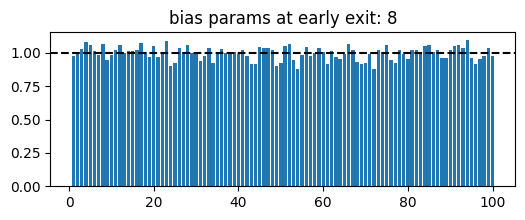

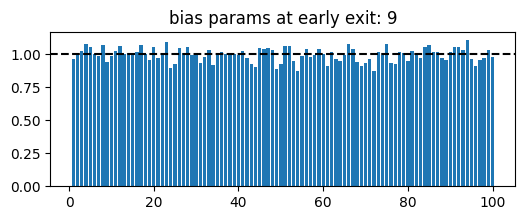

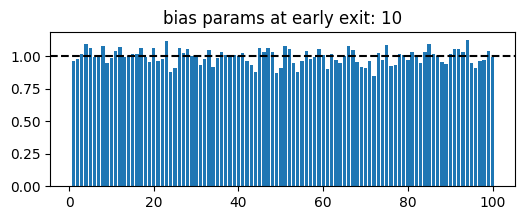

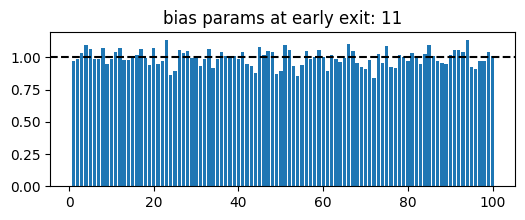

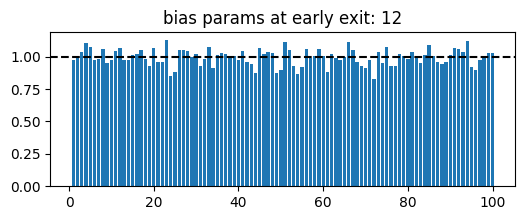

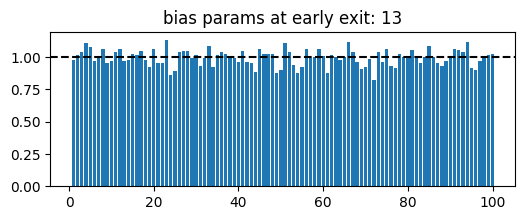

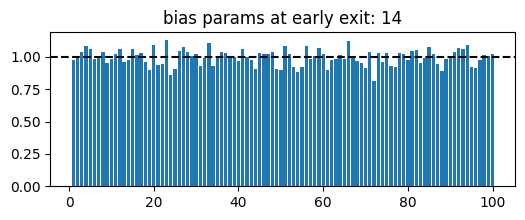

In [17]:
for l in range(N_ee):
    fig, ax = plt.subplots(figsize=(6, 2))
    plt.bar(list(range(1, 101)), ens_bias_dict[l])
    plt.axhline(y=1, color='black', linestyle='--')
    plt.title('bias params at early exit: ' + str(l + 1))
    plt.show()

### 2.1 Impact of bias ensemble parameters on peformance

In [18]:
# overwrite ensemble bias params with 0

ee_model_no_bias, ee_state_no_bias = copy.deepcopy(ee_model), copy.deepcopy(ee_state.copy())

for key in ee_state['model_state'].keys():
    if '_bias' in key and '_ensembles.' in key:
        ee_state_no_bias['model_state'][key] = torch.zeros_like(ee_state['model_state'][key])


for l in range(N_ee):
    ee_model_no_bias._ensembles[l]._bias = torch.nn.Parameter(torch.zeros_like(ee_model_no_bias._ensembles[l]._bias))

In [19]:
logits_no_bias, targets_no_bias = get_predictions_for_model(ee_model_no_bias, ee_state_no_bias)
logits_no_bias = torch.stack(logits_no_bias).cpu()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [20]:
probs_ztw_ens = torch.softmax(logits_ztw_ens, dim=2)
preds_ztw_ens = {i: torch.argmax(probs_ztw_ens, dim=2)[i, :] for i in range(L)}
acc_ztw_ens = [(targets == preds_ztw_ens[i]).sum() / len(targets) for i in range(L)]

In [21]:
probs_ztw_ens_no_bias = torch.softmax(logits_no_bias, dim=2)
preds_ztw_ens_no_bias = {i: torch.argmax(probs_ztw_ens_no_bias, dim=2)[i, :] for i in range(L)}
acc_ztw_ens_no_bias = [(targets == preds_ztw_ens_no_bias[i]).sum() / len(targets) for i in range(L)]

Impact of bias ensemble parameters on the model performance is neglible, can safely be ignored imo

In [22]:
perf_improvement_w_bias = [float(x - y) * 100 for x, y in zip(acc_ztw_ens, acc_ztw_ens_no_bias)]

In [23]:
perf_improvement_w_bias

[0.12000203132629395,
 -0.04000067710876465,
 -0.0299990177154541,
 -0.0899970531463623,
 0.010001659393310547,
 0.0,
 0.09999871253967285,
 -0.050002336502075195,
 -0.019997358322143555,
 0.10999441146850586,
 0.06999969482421875,
 -0.12000203132629395,
 0.0800013542175293,
 0.10000467300415039,
 0.0]

In [24]:
np.mean(perf_improvement_w_bias)

0.01600027084350586

### 2.2 Using ZTW ensemble weights in PoE-OvR

In [25]:
probs = torch.softmax(logits[:-1], dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(N_ee)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(N_ee)]

In [26]:
probs_ztw_ens = torch.softmax(logits_ztw_ens[:-1], dim=2)
preds_ztw_ens = {i: torch.argmax(probs_ztw_ens, dim=2)[i, :] for i in range(N_ee)}
acc_ztw_ens = [(targets == preds_ztw_ens[i]).sum() / len(targets) for i in range(N_ee)]

In [27]:
# to get ens_weights_dict run the first cell in section 2.0 above
probs_poe_ovr_break_ties_ztw_ens = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized_hetero_weights_per_ee(logits[:-1], weights=ens_weights_dict))
preds_poe_ovr_break_ties_ztw_ens = {i: torch.argmax(probs_poe_ovr_break_ties_ztw_ens, dim=2)[i, :] for i in range(N_ee)}
acc_poe_ovr_break_ties_ztw_ens = [(targets == preds_poe_ovr_break_ties_ztw_ens[i]).sum() / len(targets) for i in range(N_ee)]

In [29]:
# use ZTW weights from the last early exit in PoE-OvR
probs_poe_ovr_break_ties_ztw_ens_last = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits[:-1], weights=np.exp(ee_model._ensembles[-1]._weight.cpu().detach().numpy().squeeze())))
preds_poe_ovr_break_ties_ztw_ens_last = {i: torch.argmax(probs_poe_ovr_break_ties_ztw_ens_last, dim=2)[i, :] for i in range(N_ee)}
acc_poe_ovr_break_ties_ztw_ens_last = [(targets == preds_poe_ovr_break_ties_ztw_ens_last[i]).sum() / len(targets) for i in range(N_ee)]

In [32]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits[:-1], weights=(np.arange(1, N_ee + 1, 1, dtype=float) / N_ee) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(N_ee)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(N_ee)]

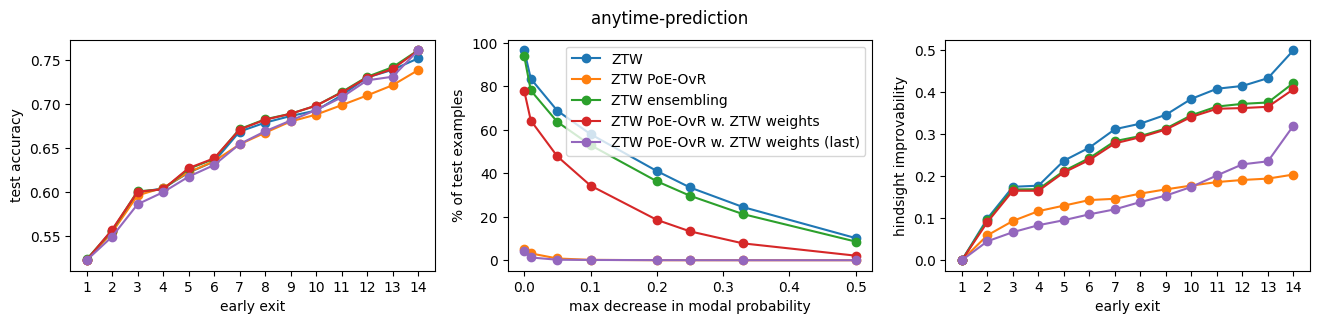

In [35]:
early_exits = [i + 1 for i in range(N_ee)]

fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(early_exits, acc, label='ZTW', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='ZTW PoE-OvR', marker='o',)
ax[0].plot(early_exits, acc_ztw_ens, label='ZTW ensembling', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_ztw_ens, label='ZTW PoE-OvR w. ZTW weights', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_ztw_ens_last, label='ZTW PoE-OvR w. ZTW weights (last)', marker='o',)

ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'ZTW'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'ZTW PoE-OvR'),
                            (preds_ztw_ens, probs_ztw_ens, 'ZTW ensembling'),
                            (preds_poe_ovr_break_ties_ztw_ens, probs_poe_ovr_break_ties_ztw_ens, 'ZTW PoE-OvR w. ZTW weights'),
                            (preds_poe_ovr_break_ties_ztw_ens_last, probs_poe_ovr_break_ties_ztw_ens_last, 'ZTW PoE-OvR w. ZTW weights (last)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, N_ee, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    ax[2].plot(early_exits, calculate_hindsight_improvability([_probs[l] for l in range(N_ee)], targets), marker='o', label=label)

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('hindsight improvability')

ax[0].set_xticks(early_exits)
ax[2].set_xticks(early_exits)

ax[1].legend(loc='upper right')
plt.suptitle(f'anytime-prediction')
plt.show()